# Libraries required for analysis

In [215]:
#importing libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
import statsmodels.api as sm

# Data for the analysis

In [216]:
def DailyTraffic(TData, Date):
    df1 = TData[TData['DATE'] == Date]
    
    df2 = df1.drop(['DIST','DIR', 'DATE'], axis=1)
    df3 = df2.sort_index()
    df4 = df3[~df3.index.duplicated()]
    df5 = df4.T
    
    Hours = pd.Series(list(range(1,25)),index=df5.index)
    df5['Hour'] = Hours
    return df5
#End of DailyTraffic

# Function to add shifted traffic data to the dataset    
def addShiftTraffic(DataSet, OneSiteTraffic, periods = 4):
    for i in range(1, periods+1):
        ShiftedTraffic = OneSiteTraffic.shift(periods=i)
        ColumnSuffix = '_' +str(i) + 'HrBf'
        DataSet = DataSet.join(ShiftedTraffic, rsuffix=ColumnSuffix)
        
    return DataSet

# Read in data from the CSV files    
#Folder = "C:/Users/faculty/Desktop/Temp/Python/CATM/Traffic Analysis/"
#Folder = "D:/Spring_2020/UTC_2020/Evacuation analysis/Hurricane Florence CSV files/"
Folder = "C:/Users/shmhatre/Desktop/Spring_2020/CATM project_2020/TrafficEvacAnalysis/Sensor_Analysis/"

Counties = pd.read_csv(Folder + "AdjacentCounty.csv", index_col="County")
Counties['Sr.No'] = Counties.index

SensorSite = pd.read_csv(Folder + "Consolidate Data.csv", index_col="SITE")

D1 = pd.read_csv(Folder + "D1.csv",index_col='SITE')
D2 = pd.read_csv(Folder + "D2.csv",index_col='SITE')
D3 = pd.read_csv(Folder + "D3.csv",index_col='SITE')
D4 = pd.read_csv(Folder + "D4.csv",index_col='SITE')
D5 = pd.read_csv(Folder + "D5.csv",index_col='SITE')
D6 = pd.read_csv(Folder + "D6.csv",index_col='SITE')

# Merge the traffic data from all files
# Then seperate them into four datasets by directions
RawData = pd.concat([D1,D2,D3,D4,D5,D6], sort=False)
EBTraffic = RawData[RawData['DIR'] == 'EB']
WBTraffic = RawData[RawData['DIR'] == 'WB']
NBTraffic = RawData[RawData['DIR'] == 'NB']
SBTraffic = RawData[RawData['DIR'] == 'SB']

# Filter the evacuation data and re-organize the dataset
Dates = ['9/5/2018', '9/6/2018', '9/7/2018', '9/8/2018', '9/9/2018']

WBframes = [0] * len(Dates)
NBframes = [0] * len(Dates)
#EBframes = [0] * len(Dates)
#SBframes = [0] * len(Dates)
for i in range(len(Dates)):
    WBframes[i] = DailyTraffic(WBTraffic, Dates[i])
    NBframes[i] = DailyTraffic(NBTraffic, Dates[i])
    #EBframes[i] = DailyTraffic(EBTraffic, Dates[i])
    #SBframes[i] = DailyTraffic(SBTraffic, Dates[i])
        
WBTData = pd.concat(WBframes, keys=Dates, sort=False)
NBTData = pd.concat(NBframes, keys=Dates, sort=False)
#EBTData = pd.concat(EBframes, keys=Dates, sort=False)
#SBTData = pd.concat(SBframes, keys=Dates, sort=False)

#EvacuationTraffic = WBTData.join(NBTData, how='outer',rsuffix='_NB')
EvacuationTraffic = WBTData.join(NBTData, how='outer',rsuffix='_NB')

# Prepare the dataset for the prediction modeling
# PredInput is the dataset for the prediction modeling
AvailableSensors = list(EvacuationTraffic.columns)
Sensor = "R9103"

PredInput = EvacuationTraffic.loc[:,[Sensor,'Hour']]

SiteTraffic = EvacuationTraffic[Sensor]
PredInput = addShiftTraffic(PredInput, SiteTraffic)

SensorCounty = SensorSite.loc[Sensor,'County']

for adjCounty in Counties.loc[SensorCounty]:
    adjSensors = SensorSite[SensorSite['County'] == adjCounty].index

    for adjSensor in adjSensors:
        if adjSensor == Sensor:
            continue
        
        print(adjSensor)
        available = AvailableSensors.count(adjSensor)        
        if available == 0:
            print('Sensor ' + adjSensor + ' is misisng!')
        elif available == 1:
            adjTraffic = EvacuationTraffic[adjSensor]
            PredInput = PredInput.join(adjTraffic)
            PredInput = addShiftTraffic(PredInput, adjTraffic)
            PredInput = PredInput.drop([adjSensor], axis=1)


R9101
R9102
R9104
R9106
R9107
R9108
Sensor R9108 is misisng!
R9111
R9112
R9113
R9114
Sensor R9114 is misisng!
R5001
A5001D4
A4201
A6301
A6302
R6301
R3103



# Data Cleaning Operations

In [217]:
#Removing first three rows containig most Null values

In [218]:

Df1 = PredInput.iloc[3:,]
Df1
#DfPredInput.fillna(axis= 1, method ='ffill')

R9103  Hour  R9103_1HrBf  R9103_2HrBf  R9103_3HrBf  \
9/5/2018 HR 4     207     4        144.0        118.0        181.0   
         HR 5     444     5        207.0        144.0        118.0   
         HR 6    1607     6        444.0        207.0        144.0   
         HR 7    2615     7       1607.0        444.0        207.0   
         HR 8    1927     8       2615.0       1607.0        444.0   
...               ...   ...          ...          ...          ...   
9/9/2018 HR 20   1806    20       2126.0       2269.0       2434.0   
         HR 21   1555    21       1806.0       2126.0       2269.0   
         HR 22   1153    22       1555.0       1806.0       2126.0   
         HR 23    761    23       1153.0       1555.0       1806.0   
         HR 24    432    24        761.0       1153.0       1555.0   

                R9103_4HrBf  R9101_1HrBf  R9101_2HrBf  R9101_3HrBf  \
9/5/2018 HR 4           NaN         37.0         46.0         60.0   
         HR 5         181.0         63.0         37.0         46.0   
         HR 6         118.0        176.0         63.0         37.0   
         HR 7         144.0        645.0        176.0         63.0   
         HR 8         207.0       1824.0        645.0        176.0   
...                     ...          ...          ...          ...   
9/9/2018 HR 20       2461.0        529.0        729.0        830.0   
         HR 21       2434.0        459.0        529.0        729.0   
         HR 22       2269.0        359.0        459.0        529.0   
         HR 23       2126.0        242.0        359.0        459.0   
         HR 24       1806.0        149.0        242.0        359.0   

                R9101_4HrBf  ...  A6302_3HrBf  A6302_4HrBf  R6301_1HrBf  \
9/5/2018 HR 4           NaN  ...          4.0          NaN          NaN   
         HR 5          60.0  ...          1.0          4.0          NaN   
         HR 6          46.0  ...          1.0          1.0          NaN   
         HR 7          37.0  ...          3.0          1.0          NaN   
         HR 8          63.0  ...          9.0          3.0          NaN   
...                     ...  ...          ...          ...          ...   
9/9/2018 HR 20        862.0  ...         38.0         31.0        778.0   
         HR 21        830.0  ...         42.0         38.0        664.0   
         HR 22        729.0  ...         42.0         42.0        556.0   
         HR 23        529.0  ...         39.0         42.0        415.0   
         HR 24        459.0  ...         27.0         39.0        316.0   

                R6301_2HrBf  R6301_3HrBf  R6301_4HrBf  R3103_1HrBf  \
9/5/2018 HR 4           NaN          NaN          NaN        175.0   
         HR 5           NaN          NaN          NaN        213.0   
         HR 6           NaN          NaN          NaN        325.0   
         HR 7           NaN          NaN          NaN        747.0   
         HR 8           NaN          NaN          NaN       1886.0   
...                     ...          ...          ...          ...   
9/9/2018 HR 20        855.0        944.0        973.0       2567.0   
         HR 21        778.0        855.0        944.0       2273.0   
         HR 22        664.0        778.0        855.0       1705.0   
         HR 23        556.0        664.0        778.0       1219.0   
         HR 24        415.0        556.0        664.0        828.0   

                R3103_2HrBf  R3103_3HrBf  R3103_4HrBf  
9/5/2018 HR 4         259.0        441.0          NaN  
         HR 5         175.0        259.0        441.0  
         HR 6         213.0        175.0        259.0  
         HR 7         325.0        213.0        175.0  
         HR 8         747.0        325.0        213.0  
...                     ...          ...          ...  
9/9/2018 HR 20       3186.0       3379.0       3440.0  
         HR 21       2567.0       3186.0       3379.0  
         HR 22       2273.0       2567.0       3186.0  
         HR 23       1705.0     

In [219]:
# Dropping null values from columns

In [220]:
Data = Df1.dropna(axis=1)
Data

R9103  Hour  R9103_1HrBf  R9103_2HrBf  R9103_3HrBf  \
9/5/2018 HR 4     207     4        144.0        118.0        181.0   
         HR 5     444     5        207.0        144.0        118.0   
         HR 6    1607     6        444.0        207.0        144.0   
         HR 7    2615     7       1607.0        444.0        207.0   
         HR 8    1927     8       2615.0       1607.0        444.0   
...               ...   ...          ...          ...          ...   
9/9/2018 HR 20   1806    20       2126.0       2269.0       2434.0   
         HR 21   1555    21       1806.0       2126.0       2269.0   
         HR 22   1153    22       1555.0       1806.0       2126.0   
         HR 23    761    23       1153.0       1555.0       1806.0   
         HR 24    432    24        761.0       1153.0       1555.0   

                R9101_1HrBf  R9101_2HrBf  R9101_3HrBf  R9102_1HrBf  \
9/5/2018 HR 4          37.0         46.0         60.0        116.0   
         HR 5          63.0         37.0         46.0         68.0   
         HR 6         176.0         63.0         37.0         53.0   
         HR 7         645.0        176.0         63.0        166.0   
         HR 8        1824.0        645.0        176.0        609.0   
...                     ...          ...          ...          ...   
9/9/2018 HR 20        529.0        729.0        830.0        721.0   
         HR 21        459.0        529.0        729.0        677.0   
         HR 22        359.0        459.0        529.0        647.0   
         HR 23        242.0        359.0        459.0        470.0   
         HR 24        149.0        242.0        359.0        304.0   

                R9102_2HrBf  ...  A4201_3HrBf  A6301_1HrBf  A6301_2HrBf  \
9/5/2018 HR 4         105.0  ...         30.0         54.0         31.0   
         HR 5         116.0  ...         28.0         55.0         54.0   
         HR 6          68.0  ...         26.0        160.0         55.0   
         HR 7          53.0  ...         26.0        501.0        160.0   
         HR 8         166.0  ...         65.0       1133.0        501.0   
...                     ...  ...          ...          ...          ...   
9/9/2018 HR 20        848.0  ...        505.0        889.0       1024.0   
         HR 21        721.0  ...        513.0        691.0        889.0   
         HR 22        677.0  ...        472.0        625.0        691.0   
         HR 23        647.0  ...        443.0        422.0        625.0   
         HR 24        470.0  ...        306.0        261.0        422.0   

                A6301_3HrBf  A6302_1HrBf  A6302_2HrBf  A6302_3HrBf  \
9/5/2018 HR 4          71.0          1.0          1.0          4.0   
         HR 5          31.0          3.0          1.0          1.0   
         HR 6          54.0          9.0          3.0          1.0   
         HR 7          55.0         39.0          9.0          3.0   
         HR 8         160.0         50.0         39.0          9.0   
...                     ...          ...          ...          ...   
9/9/2018 HR 20       1046.0         42.0         42.0         38.0   
         HR 21       1024.0         39.0         42.0         42.0   
         HR 22        889.0         27.0         39.0         42.0   
         HR 23        691.0         15.0         27.0         39.0   
         HR 24        625.0          8.0         15.0         27.0   

                R3103_1HrBf  R3103_2HrBf  R3103_3HrBf  
9/5/2018 HR 4         175.0        259.0        441.0  
         HR 5         213.0        175.0        259.0  
         HR 6         325.0        213.0        175.0  
         HR 7         747.0        325.0        213.0  
         HR 8        1886.0        747.0        325.0  
...                     ...          ...          ...  
9/9/2018 HR 20       2567.0       3186.0       3379.0  
         HR 21       2273.0       2567.0       3186.0  
         HR 22       1705.0       2273.0       2567.0  
         HR 23       1219.0     

In [221]:
#X and Y arrays
#cat_feat = ['Hour']
#Final_Data = pd.get_dummies(Data, columns= cat_feat, drop_first=True)
X = Data.drop(['R9103','Hour'] ,axis=1)
y = Data['R9103']
y

9/5/2018  HR 4      207
          HR 5      444
          HR 6     1607
          HR 7     2615
          HR 8     1927
                   ... 
9/9/2018  HR 20    1806
          HR 21    1555
          HR 22    1153
          HR 23     761
          HR 24     432
Name: R9103, Length: 117, dtype: int64

# Feature Extraction using 

## Backward elimination Method
As the name suggest, we feed all the possible features to the model at first. We check the performance of the model 
and then iteratively remove the worst performing features one by one till the overall performance of the model comes 
in acceptable range. 

The performance metric used here to evaluate feature performance is pvalue. If the pvalue is above 0.05 then 
we remove the feature, else we keep it.

We will first run one iteration here just to get an idea of the concept and then we will run the same code in a loop, 
which will give the final set of features. Here we are using OLS model which stands for “Ordinary Least Squares”. 
This model is used for performing linear regression

In [222]:
#Adding constant column of ones, mandatory for sm.OLS model
X_1 = sm.add_constant(X)
#Fitting sm.OLS model
model = sm.OLS(y,X_1).fit()
#model.pvalues

In [223]:
#Backward Elimination
cols = list(X.columns)
pmax = 1
while (len(cols)>0):
    p= []
    X_1 = X[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(y,X_1).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.05):
        cols.remove(feature_with_p_max)
    else:
        break
selected_features_BE = cols
#outF = open("myOutFile.txt", "w")
#for data in selected_features_BE:
  #print(outF, data)
#outF.close()
print(selected_features_BE)

['R9103_1HrBf', 'R9101_1HrBf', 'R9107_2HrBf', 'R9111_2HrBf', 'R9112_2HrBf', 'R9113_2HrBf', 'A5001D4_1HrBf', 'A5001D4_2HrBf', 'R3103_3HrBf']


In [224]:
#Adding constant column of ones, mandatory for sm.OLS model
X_1 = sm.add_constant(X)
#Fitting sm.OLS model
model = sm.OLS(y,X_1).fit()
#model.pvalues

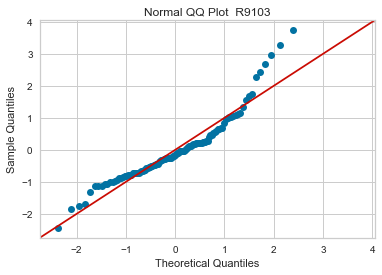

In [225]:
X2 = sm.add_constant(X)
model = sm.OLS(y, X2)
result = model.fit()
res = result.resid
fig = sm.qqplot(res,fit=True,line ='45')
#probplot = sm.ProbPlot(res)
# fig = probplot.qqplot()
h = plt.title('Normal QQ Plot  ' +Sensor)
plt.savefig("C:/Users/shmhatre/Desktop/Spring_2020/CATM project_2020/TrafficEvacAnalysis/Informs_result/" + Sensor+'_qqplot.png',transparent = True, dpi= 1000, bbox_inches ='tight')
plt.show()

In [ ]:
#writing out the residual to fins the outier

In [226]:
res
res.to_excel("C:/Users/shmhatre/Desktop/Spring_2020/CATM project_2020/TrafficEvacAnalysis/Sensor_Analysis/" + "res" + Sensor + ".xlsx")

In [227]:
# Shapiro-Wilk Test
from numpy.random import seed
from numpy.random import randn
from scipy.stats import shapiro
# seed the random number generator
#seed(1)
# generate univariate observations
data = res
# normality test
stat, p = shapiro(data)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Sample looks Gaussian (fail to reject H0)')
else:
	print('Sample does not look Gaussian (reject H0)')

Statistics=0.922, p=0.000
Sample does not look Gaussian (reject H0)


In [228]:
# D'Agostino and Pearson's Test
from numpy.random import seed
from numpy.random import randn
from scipy.stats import normaltest
# seed the random number generator
#seed(1)
# generate univariate observations
data = res
# normality test
stat, p = normaltest(data)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Sample looks Gaussian (fail to reject H0)')
else:
	print('Sample does not look Gaussian (reject H0)')

Statistics=30.414, p=0.000
Sample does not look Gaussian (reject H0)


In [229]:
# Anderson-Darling Test
from numpy.random import seed
from numpy.random import randn
from scipy.stats import anderson
# seed the random number generator
seed(1)
# generate univariate observations
data = res
# normality test
result = anderson(data)
print('Statistic: %.3f' % result.statistic)
p = 0
for i in range(len(result.critical_values)):
	sl, cv = result.significance_level[i], result.critical_values[i]
	if result.statistic < result.critical_values[i]:
		print('%.3f: %.3f, data looks normal (fail to reject H0)' % (sl, cv))
	else:
		print('%.3f: %.3f, data does not look normal (reject H0)' % (sl, cv))

Statistic: 2.583
15.000: 0.558, data does not look normal (reject H0)
10.000: 0.635, data does not look normal (reject H0)
5.000: 0.762, data does not look normal (reject H0)
2.500: 0.889, data does not look normal (reject H0)
1.000: 1.058, data does not look normal (reject H0)


## Visualisation for Cook’s distance (CD) to identify the most influential observation in outlier detection

C:\Users\shmhatre\Anaconda3\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
C:\Users\shmhatre\Anaconda3\lib\site-packages\yellowbrick\regressor\influence.py:183: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  self.distance_, linefmt=self.linefmt, markerfmt=self.markerfmt


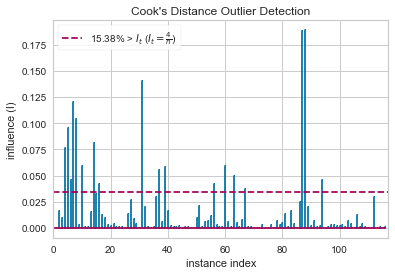

In [230]:
# Instantiate and fit the visualizer
#with ('9/5/2018', 'HR 9'),('9/6/2018', 'HR 8'),('9/8/2018', 'HR 19'),('9/8/2018', 'HR 22') dropping
from yellowbrick.regressor import CooksDistance
visualizer = CooksDistance()
visualizer.fit(X, y)
visualizer.show()

In [186]:
#Adding constant column of ones, mandatory for sm.OLS model
X_1 = sm.add_constant(X)
#Fitting sm.OLS model
model = sm.OLS(y,X_1).fit()
#model.pvalues

In [116]:
from statsmodels.formula.api import ols
infl = model.get_influence()
sm_fr = infl.summary_frame()
sm_fr

dfb_const  dfb_R3103_1HrBf  dfb_R3103_2HrBf  dfb_R3103_3HrBf  \
9/5/2018 HR 4   -0.105099         0.013758         0.006146        -0.021535   
         HR 5   -0.064657         0.009584        -0.002736        -0.006978   
         HR 6    0.034611        -0.006619         0.003311        -0.001550   
         HR 7    0.001585        -0.002984        -0.002824        -0.000172   
         HR 8    0.136481        -0.020924         0.001388         0.002915   
...                   ...              ...              ...              ...   
9/9/2018 HR 20   0.036166         0.025816        -0.017158        -0.019245   
         HR 21  -0.070696         0.083829         0.102286        -0.160004   
         HR 22  -0.008051         0.315095        -0.133675        -0.022750   
         HR 23  -0.000244         0.015166         0.004900        -0.012034   
         HR 24   0.000992         0.010740         0.006616        -0.001736   

                dfb_R9101_1HrBf  dfb_R9101_2HrBf  dfb_R9101_3HrBf  \
9/5/2018 HR 4         -0.006470         0.008106        -0.009195   
         HR 5          0.009271         0.000333         0.001892   
         HR 6         -0.010917         0.000201        -0.005569   
         HR 7         -0.006453         0.003759        -0.003227   
         HR 8         -0.007908         0.161920        -0.099044   
...                         ...              ...              ...   
9/9/2018 HR 20         0.072979         0.013015        -0.011559   
         HR 21        -0.046362         0.471137         0.005009   
         HR 22         0.028564        -0.033617         0.373838   
         HR 23        -0.010243         0.019264         0.006652   
         HR 24        -0.017384         0.034277         0.009738   

                dfb_R9102_1HrBf  dfb_R9102_2HrBf  dfb_R9102_3HrBf  ...  \
9/5/2018 HR 4         -0.038390         0.012874         0.021370  ...   
         HR 5         -0.003314        -0.023754         0.034643  ...   
         HR 6          0.005669        -0.002062         0.006666  ...   
         HR 7          0.001409        -0.000907         0.000715  ...   
         HR 8          0.196253        -0.009659        -0.027803  ...   
...                         ...              ...              ...  ...   
9/9/2018 HR 20         0.023262         0.037266        -0.004754  ...   
         HR 21         0.091149         0.013195         0.202910  ...   
         HR 22        -0.063085        -0.021460         0.171781  ...   
         HR 23         0.006500        -0.008109         0.016181  ...   
         HR 24         0.026664         0.001604         0.006585  ...   

                dfb_R9112_3HrBf  dfb_R9113_1HrBf  dfb_R9113_2HrBf  \
9/5/2018 HR 4         -0.019628         0.042940         0.003506   
         HR 5          0.007451        -0.011610         0.031507   
         HR 6          0.020329         0.007438        -0.000223   
         HR 7          0.000719        -0.005973         0.003129   
         HR 8          0.064913        -0.006027         0.140121   
...                         ...              ...              ...   
9/9/2018 HR 20         0.049370         0.049551        -0.006748   
         HR 21         0.018571        -0.078931         0.289114   
         HR 22        -0.025654        -0.228556        -0.063401   
         HR 23         0.008778        -0.005222        -0.013126   
         HR 24         0.021804         0.007749        -0.025674   

                dfb_R9113_3HrBf   cooks_d  standard_resid  hat_diag  \
9/5/2018 HR 4          0.019613  0.000493       -0.442443  0.065921   
         HR 5          0.002160  0.000258       -0.312672  0.068863   
         HR 6         -0.026413  0.000150        0.254332  0.061012   
         HR 7         -0.002371  0.000019        0.050331  0.170813   
         HR 8         -0.166344  0.019792       -1.063121  0.329009   
...                         ...       ...             ...       ...   
9/9/2018 HR

In [ ]:
#Writing out the file to find the infulencial observation

In [117]:
sm_fr.to_excel("C:/Users/shmhatre/Desktop/Spring_2020/CATM project_2020/TrafficEvacAnalysis/Sensor_Analysis/" + "CD" + Sensor + ".xlsx")

## we drop the observation with CD > (4/n) where ‘n’ is the total number of the observations 

In [208]:
X.drop([('9/5/2018', 'HR 6'), ('9/5/2018', 'HR 7'),('9/6/2018', 'HR 6'),('9/6/2018', 'HR 7'), ('9/6/2018', 'HR 17'),
        ('9/7/2018', 'HR 6'),('9/7/2018', 'HR 7'),('9/8/2018', 'HR 19'),('9/8/2018', 'HR 20')],axis=0, inplace=True)
X 

R9103_1HrBf  R9103_2HrBf  R9103_3HrBf  R9101_1HrBf  \
9/5/2018 HR 4         144.0        118.0        181.0         37.0   
         HR 5         207.0        144.0        118.0         63.0   
         HR 8        2615.0       1607.0        444.0       1824.0   
         HR 9        1927.0       2615.0       1607.0       1906.0   
         HR 10       1543.0       1927.0       2615.0       1512.0   
...                     ...          ...          ...          ...   
9/9/2018 HR 20       2126.0       2269.0       2434.0        529.0   
         HR 21       1806.0       2126.0       2269.0        459.0   
         HR 22       1555.0       1806.0       2126.0        359.0   
         HR 23       1153.0       1555.0       1806.0        242.0   
         HR 24        761.0       1153.0       1555.0        149.0   

                R9101_2HrBf  R9101_3HrBf  R9102_1HrBf  R9102_2HrBf  \
9/5/2018 HR 4          46.0         60.0        116.0        105.0   
         HR 5          37.0         46.0         68.0        116.0   
         HR 8         645.0        176.0        609.0        166.0   
         HR 9        1824.0        645.0       1258.0        609.0   
         HR 10       1906.0       1824.0       1212.0       1258.0   
...                     ...          ...          ...          ...   
9/9/2018 HR 20        729.0        830.0        721.0        848.0   
         HR 21        529.0        729.0        677.0        721.0   
         HR 22        459.0        529.0        647.0        677.0   
         HR 23        359.0        459.0        470.0        647.0   
         HR 24        242.0        359.0        304.0        470.0   

                R9102_3HrBf  R9106_1HrBf  ...  A4201_3HrBf  A6301_1HrBf  \
9/5/2018 HR 4         174.0        208.0  ...         30.0         54.0   
         HR 5         105.0        249.0  ...         28.0         55.0   
         HR 8          53.0       3302.0  ...         65.0       1133.0   
         HR 9         166.0       4578.0  ...        236.0       1102.0   
         HR 10        609.0       4008.0  ...        517.0        920.0   
...                     ...          ...  ...          ...          ...   
9/9/2018 HR 20        979.0       2394.0  ...        505.0        889.0   
         HR 21        848.0       2186.0  ...        513.0        691.0   
         HR 22        721.0       1793.0  ...        472.0        625.0   
         HR 23        677.0       1313.0  ...        443.0        422.0   
         HR 24        647.0        921.0  ...        306.0        261.0   

                A6301_2HrBf  A6301_3HrBf  A6302_1HrBf  A6302_2HrBf  \
9/5/2018 HR 4          31.0         71.0          1.0          1.0   
         HR 5          54.0         31.0          3.0          1.0   
         HR 8         501.0        160.0         50.0         39.0   
         HR 9        1133.0        501.0         66.0         50.0   
         HR 10       1102.0       1133.0         49.0         66.0   
...                     ...          ...          ...          ...   
9/9/2018 HR 20       1024.0       1046.0         42.0         42.0   
         HR 21        889.0       1024.0         39.0         42.0   
         HR 22        691.0        889.0         27.0         39.0   
         HR 23        625.0        691.0         15.0         27.0   
         HR 24        422.0        625.0          8.0         15.0   

                A6302_3HrBf  R3103_1HrBf  R3103_2HrBf  R3103_3HrBf  
9/5/2018 HR 4           4.0        175.0        259.0        441.0  
         HR 5           1.0        213.0        175.0        259.0  
         HR 8           9.0       1886.0        747.0        325.0  
         HR 9          39.0       3281.0       1886.0        747.0  
         HR 10         50.0       3313.0       3281.0       1886.0  
...                     ...          ...          ...          ...  
9/9/2018 HR 20         38.0       2567.0       3186.0       3379.0  
         HR 21         42.0       2273.0

In [209]:
y.drop([('9/5/2018', 'HR 6'), ('9/5/2018', 'HR 7'),('9/6/2018', 'HR 6'),('9/6/2018', 'HR 7'), ('9/6/2018', 'HR 17'),
        ('9/7/2018', 'HR 6'),('9/7/2018', 'HR 7'),('9/8/2018', 'HR 19'),('9/8/2018', 'HR 20')],axis=0, inplace=True)
y

C:\Users\shmhatre\Anaconda3\lib\site-packages\pandas\core\generic.py:3939: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(obj)


9/5/2018  HR 4      207
          HR 5      444
          HR 8     1927
          HR 9     1543
          HR 10    2119
                   ... 
9/9/2018  HR 20    1806
          HR 21    1555
          HR 22    1153
          HR 23     761
          HR 24     432
Name: R9103, Length: 108, dtype: int64

C:\Users\shmhatre\Anaconda3\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
C:\Users\shmhatre\Anaconda3\lib\site-packages\yellowbrick\regressor\influence.py:183: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  self.distance_, linefmt=self.linefmt, markerfmt=self.markerfmt


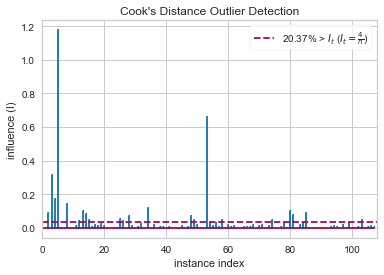

In [210]:
# Instantiate and fit the visualizer
#with ('9/5/2018', 'HR 9'),('9/6/2018', 'HR 8'),('9/8/2018', 'HR 19'),('9/8/2018', 'HR 22') dropping
from yellowbrick.regressor import CooksDistance
visualizer = CooksDistance()
visualizer.fit(X, y)
visualizer.show()

In [88]:
#Adding constant column of ones, mandatory for sm.OLS model
X_1 = sm.add_constant(X)
#Fitting sm.OLS model
model = sm.OLS(y,X_1).fit()
#model.pvalues

In [15]:
sm_fr.to_excel("C:/Users/shmhatre/Desktop/Spring_2020/CATM project_2020/TrafficEvacAnalysis/Sensor_Analysis/" + "7RS" + Sensor + ".xlsx")

## After dropping the observations, we fit the model with data and again check for ‘goodness of fit.

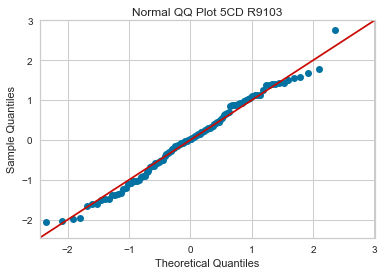

In [211]:
X2 = sm.add_constant(X)
model = sm.OLS(y, X2)
result = model.fit()
res = result.resid
fig = sm.qqplot(res,fit=True,line ='45')
#probplot = sm.ProbPlot(res)
# fig = probplot.qqplot()
h = plt.title('Normal QQ Plot 9RES ' +Sensor)
plt.savefig("C:/Users/shmhatre/Desktop/Spring_2020/CATM project_2020/TrafficEvacAnalysis/Informs_result/" + Sensor+'_qqplot.png',transparent = True, dpi= 1000, bbox_inches ='tight')
plt.show()

In [ ]:
#Normality check

In [212]:
# Shapiro-Wilk Test
from numpy.random import seed
from numpy.random import randn
from scipy.stats import shapiro
# seed the random number generator
#seed(1)
# generate univariate observations
data = res
# normality test
stat, p = shapiro(data)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Sample looks Gaussian (fail to reject H0)')
else:
	print('Sample does not look Gaussian (reject H0)')

Statistics=0.986, p=0.312
Sample looks Gaussian (fail to reject H0)


In [213]:
# D'Agostino and Pearson's Test
from numpy.random import seed
from numpy.random import randn
from scipy.stats import normaltest
# seed the random number generator
#seed(1)
# generate univariate observations
data = res
# normality test
stat, p = normaltest(data)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Sample looks Gaussian (fail to reject H0)')
else:
	print('Sample does not look Gaussian (reject H0)')

Statistics=1.737, p=0.419
Sample looks Gaussian (fail to reject H0)


In [214]:
# Anderson-Darling Test
from numpy.random import seed
from numpy.random import randn
from scipy.stats import anderson
# seed the random number generator
seed(1)
# generate univariate observations
data = res
# normality test
result = anderson(data)
print('Statistic: %.3f' % result.statistic)
p = 0
for i in range(len(result.critical_values)):
	sl, cv = result.significance_level[i], result.critical_values[i]
	if result.statistic < result.critical_values[i]:
		print('%.3f: %.3f, data looks normal (fail to reject H0)' % (sl, cv))
	else:
		print('%.3f: %.3f, data does not look normal (reject H0)' % (sl, cv))

Statistic: 0.367
15.000: 0.557, data looks normal (fail to reject H0)
10.000: 0.634, data looks normal (fail to reject H0)
5.000: 0.760, data looks normal (fail to reject H0)
2.500: 0.887, data looks normal (fail to reject H0)
1.000: 1.055, data looks normal (fail to reject H0)
